<a href="https://colab.research.google.com/github/NehaKumari500092077/Deep-Learning-Lab/blob/main/Programming%20Assignment%206%20Solution.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preprocessing on dataset

In [ ]:
import torch
from torch.utils.data import DataLoader, random_split
import torchvision.transforms as transforms
from torchvision.datasets import DTD
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torchvision
import pickle
from math import sqrt, ceil
from timeit import default_timer as timer

import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from torchsummary import summary

# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("puneet6060/intel-image-classification")

print("Path to dataset files:", path)

100%|██████████| 346M/346M [00:01<00:00, 205MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/puneet6060/intel-image-classification/versions/2


In [ ]:
import os
import random
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Subset

os.listdir(path)

['seg_train', 'seg_test', 'seg_pred']

In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((16, 16)),  # Resize to 16x16
    transforms.ToTensor(),  # Convert image to tensor
])

# Paths to the folders
train_dir = path + "/seg_train/seg_train"
val_dir = path + "/seg_train/seg_train"
test_dir = path + "/seg_test/seg_test"

# Load datasets using ImageFolder
full_train_dataset = ImageFolder(root=train_dir, transform=transform)
full_test_dataset = ImageFolder(root=test_dir, transform=transform)
full_pred_dataset = ImageFolder(root=val_dir, transform=transform)

# Helper function to get subset with a fixed number of samples per class
def get_subset_with_limit(dataset, samples_per_class):
    class_indices = {cls: [] for cls in range(len(dataset.classes))}
    for idx, (_, label) in enumerate(dataset):
        class_indices[label].append(idx)

    # Randomly sample from each class
    selected_indices = []
    for indices in class_indices.values():
        selected_indices.extend(random.sample(indices, min(len(indices), samples_per_class)))
    return Subset(dataset, selected_indices)

# Create subsets for training, validation, and testing
train_dataset = get_subset_with_limit(full_train_dataset, 500)  # 500 images per class
val_dataset = get_subset_with_limit(full_train_dataset, 100)  # 100 images per class (validation from training data)
test_dataset = get_subset_with_limit(full_test_dataset, 100)  # 100 images per class from test folder

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

In [ ]:
# Print dataset sizes
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 3000
Validation size: 600
Test size: 600


In [ ]:
import random

# Shuffle the dataset
def shuffle_dataset(dataset):
    dataset_list = list(dataset)  # Convert Subset to a list
    random.shuffle(dataset_list)  # Shuffle the dataset
    return dataset_list

# Extract X (features) and y (labels) from a dataset
def extract_features_labels(dataset):
    X = []
    y = []
    shuffled_dataset = shuffle_dataset(dataset)  # Shuffle before extracting
    for data, label in shuffled_dataset:
        X.append(data.numpy())  # Convert tensor to numpy
        y.append(label)
    return X, y

# Shuffle and extract data from train, validation, and test datasets
X_train, y_train = extract_features_labels(train_dataset)
X_val, y_val = extract_features_labels(val_dataset)
X_test, y_test = extract_features_labels(test_dataset)

# Convert to NumPy arrays
X_train = np.asarray(X_train)
X_val = np.asarray(X_val)
X_test = np.asarray(X_test)

y_train = np.asarray(y_train)
y_test = np.asarray(y_test)
y_val = np.asarray(y_val)

In [ ]:
# Print shapes to verify
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (3000, 3, 16, 16), y_train shape: (3000,)
X_val shape: (600, 3, 16, 16), y_val shape: (600,)
X_test shape: (600, 3, 16, 16), y_test shape: (600,)


In [ ]:
labels = ["buildings","forest","glacier","mountain","sea","street"]

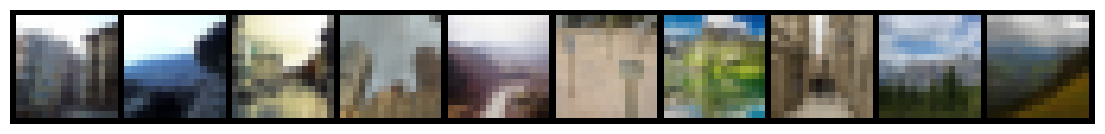

In [ ]:
# Plotting images from the 1st batch
plt.rcParams['figure.figsize'] = 14, 6

dataiter = iter(train_loader)
images, labels = next(dataiter)
plt.imshow(np.transpose(torchvision.utils.make_grid(
  images[:10], normalize=False, padding=1, nrow=10).numpy(), (1, 2, 0)))
plt.axis('off')
plt.show()

In [ ]:
from collections import Counter

# Function to count the number of images per class
def count_images_per_class(data_loader, num_classes=6):
    class_counts = np.zeros(num_classes, dtype=int)
    for _, labels in data_loader:
        label_counts = Counter(labels.numpy())  # Count occurrences in the batch
        for label, count in label_counts.items():
            class_counts[label] += count
    return class_counts

# Count images for training and validation datasets
train_class_counts = count_images_per_class(train_loader)
test_class_counts = count_images_per_class(test_loader)
val_class_counts = count_images_per_class(val_loader)

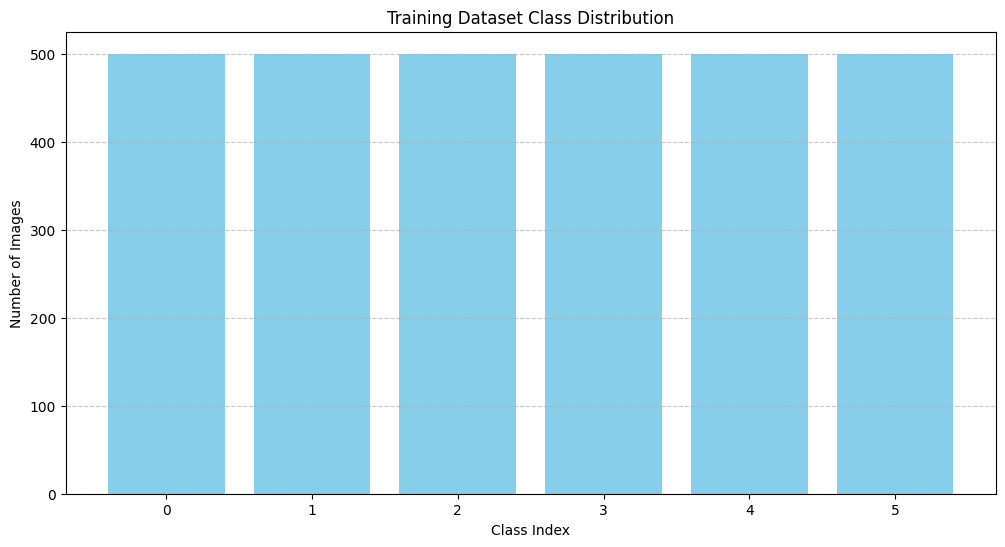

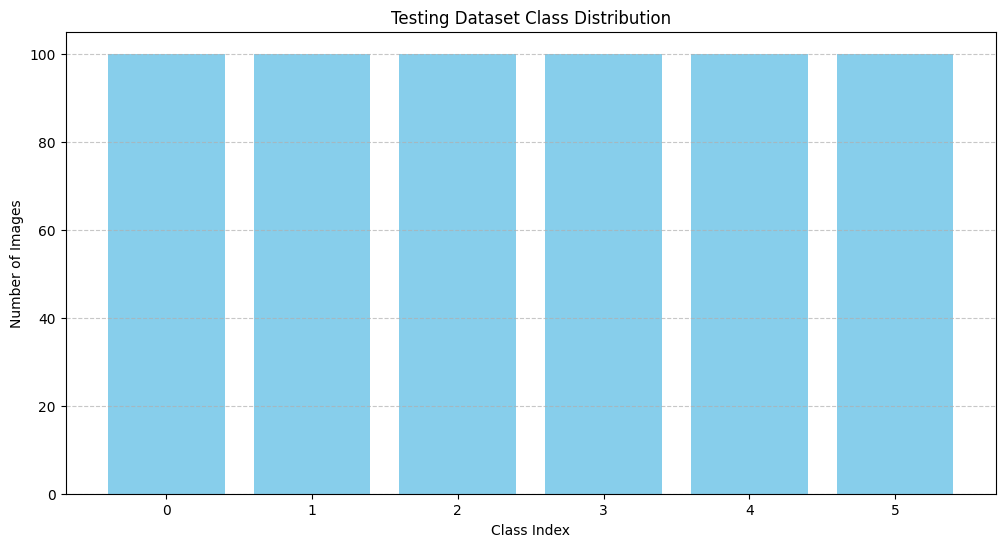

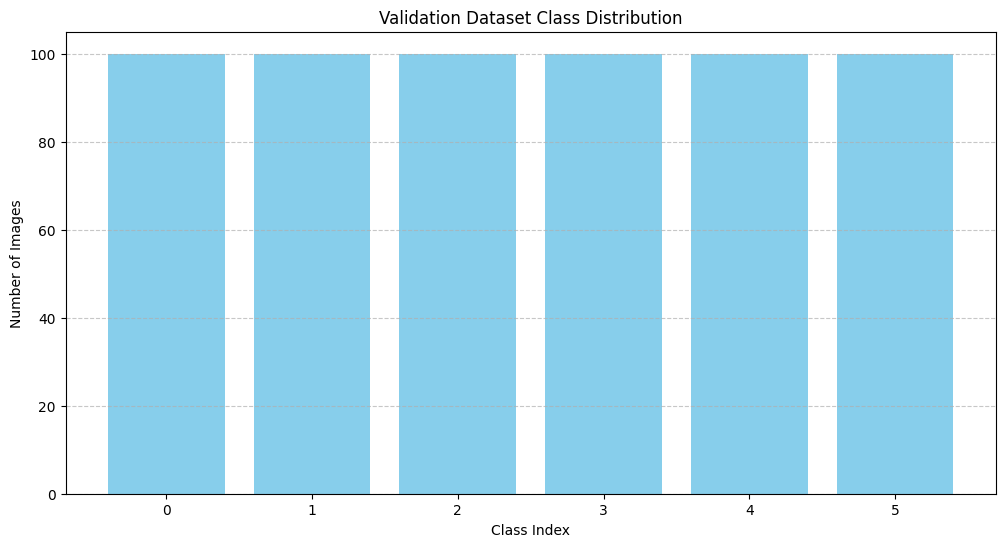

In [ ]:
# Function to plot class distribution
def plot_class_distribution(class_counts, title):
    plt.figure(figsize=(12, 6))
    plt.bar(range(len(class_counts)), class_counts, color='skyblue')
    plt.xlabel("Class Index")
    plt.ylabel("Number of Images")
    plt.title(title)
    plt.xticks(range(len(class_counts)))  # Show all class indices
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

# Plot training and validation distributions
plot_class_distribution(train_class_counts, "Training Dataset Class Distribution")
plot_class_distribution(test_class_counts, "Testing Dataset Class Distribution")
plot_class_distribution(val_class_counts, "Validation Dataset Class Distribution")


# Implementation Of CNN From Scratch

In [ ]:
class Conv2D:
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding

        # Initialization for weights: Helps with proper gradient flow
        self.weights = np.random.randn(out_channels, in_channels, kernel_size, kernel_size) * np.sqrt(2.0 / (in_channels * kernel_size * kernel_size))
        self.bias = np.zeros(out_channels)

    # Forward Pass: Computes the output feature map after applying convolution.
    def forward(self, x):
        # Get input dimensions
        batch_size, in_channels, height, width = x.shape
        # Apply padding: Adds zeros around the input feature map
        padded_x = np.pad(x, ((0, 0), (0, 0), (self.padding, self.padding), (self.padding, self.padding)), mode='constant')
        # Compute output dimensions based on convolution formula
        out_height = (height + 2 * self.padding - self.kernel_size) // self.stride + 1
        out_width = (width + 2 * self.padding - self.kernel_size) // self.stride + 1
        # Initialize output tensor with zeros
        output = np.zeros((batch_size, self.out_channels, out_height, out_width))

        # Perform convolution operation
        for b in range(batch_size):  # Iterate over batch
            for oc in range(self.out_channels):  # Iterate over output channels (filters)
                for oh in range(out_height):  # Iterate over output height
                    for ow in range(out_width):  # Iterate over output width
                        # Define region of interest in the input
                        h_start = oh * self.stride
                        h_end = h_start + self.kernel_size
                        w_start = ow * self.stride
                        w_end = w_start + self.kernel_size

                        # Perform element-wise multiplication between filter and input region
                        # Sum the values and add bias
                        output[b, oc, oh, ow] = np.sum(padded_x[b, :, h_start:h_end, w_start:w_end] * self.weights[oc]) + self.bias[oc]

        # Store input for use in backpropagation
        self.x = padded_x
        return output

    # Backward Pass: Computes gradients of weights and biases
    def backward(self, grad_output, learning_rate):
        # grad_output: Gradient of loss with respect to output of this layer (batch_size, out_channels, out_height, out_width)
        batch_size, out_channels, out_height, out_width = grad_output.shape

        # Initialize gradients for weights, bias, and input
        grad_weights = np.zeros_like(self.weights)  # Gradient w.r.t weights
        grad_bias = np.zeros_like(self.bias)  # Gradient w.r.t bias
        grad_input = np.zeros_like(self.x)  # Gradient w.r.t input

        # Compute gradients
        for b in range(batch_size):  # Iterate over batch
            for oc in range(out_channels):  # Iterate over output channels
                for oh in range(out_height):  # Iterate over output height
                    for ow in range(out_width):  # Iterate over output width
                        # Define region of interest in the padded input
                        h_start = oh * self.stride
                        h_end = h_start + self.kernel_size
                        w_start = ow * self.stride
                        w_end = w_start + self.kernel_size

                        # Compute gradient of weights (dL/dW)
                        # grad_output[b, oc, oh, ow] represents how much the output at (oh, ow) affects the loss
                        grad_weights[oc] += grad_output[b, oc, oh, ow] * self.x[b, :, h_start:h_end, w_start:w_end]

                        # Compute gradient of bias (dL/db)
                        grad_bias[oc] += grad_output[b, oc, oh, ow]

                        # Compute gradient of input (dL/dX)
                        # Identify the input region that contributed to this output pixel.
                        # Distribute the gradient back to this region by multiplying the filter weights by grad_output[b, oc, oh, ow]
                        # The update added to grad_input at this region:
                        grad_input[b, :, h_start:h_end, w_start:w_end] += grad_output[b, oc, oh, ow] * self.weights[oc]

        # Update weights and bias using gradient descent
        self.weights -= learning_rate * grad_weights
        self.bias -= learning_rate * grad_bias

        # Return the gradient of input after removing padding
        return grad_input[:, :, self.padding:self.x.shape[2]-self.padding, self.padding:self.x.shape[3]-self.padding]

class ReLU:
    # Forward Pass: Applies the ReLU activation function element-wise.
    def forward(self, x):
        self.x = x  # Store input for use in backward pass
        return np.maximum(0, x)  # Apply ReLU: max(0, x)

    # Backward Pass: Computes the gradient of the loss w.r.t the input.
    def backward(self, grad_output, learning_rate):
        return grad_output * (self.x > 0)  # Gradient is 1 where x > 0, otherwise 0


class MaxPool2D:
    def __init__(self, pool_size=2, stride=2):
        self.pool_size = pool_size  # Size of the pooling window
        self.stride = stride  # Step size for the pooling operation

    # Forward Pass: Applies max pooling to the input feature maps.
    def forward(self, x):
        # Extract input dimensions
        batch_size, in_channels, height, width = x.shape

        # Compute output dimensions after pooling
        out_height = (height - self.pool_size) // self.stride + 1
        out_width = (width - self.pool_size) // self.stride + 1

        # Initialize output tensor with zeros
        output = np.zeros((batch_size, in_channels, out_height, out_width))

        # Apply max pooling operation
        for b in range(batch_size):  # Iterate over batches
            for ic in range(in_channels):  # Iterate over input channels
                for oh in range(out_height):  # Iterate over output height
                    for ow in range(out_width):  # Iterate over output width
                        # Define pooling window boundaries
                        h_start = oh * self.stride
                        h_end = h_start + self.pool_size
                        w_start = ow * self.stride
                        w_end = w_start + self.pool_size

                        # Perform max pooling by selecting the maximum value in the region
                        output[b, ic, oh, ow] = np.max(x[b, ic, h_start:h_end, w_start:w_end])

        # Store input for use in backward pass
        self.x = x
        return output

    # Backward Pass: Computes the gradient of the loss w.r.t the input.
    def backward(self, grad_output, learning_rate):
        # grad_output: Gradient of loss w.r.t output of this layer (same shape as pooled output)
        batch_size, in_channels, out_height, out_width = grad_output.shape # Extract dimensions

        # Initialize gradient tensor with zeros
        grad_input = np.zeros_like(self.x)

        # Compute gradient propagation for max pooling
        for b in range(batch_size):  # Iterate over batches
            for ic in range(in_channels):  # Iterate over input channels
                for oh in range(out_height):  # Iterate over output height
                    for ow in range(out_width):  # Iterate over output width
                        # Define pooling window boundaries
                        h_start = oh * self.stride
                        h_end = h_start + self.pool_size
                        w_start = ow * self.stride
                        w_end = w_start + self.pool_size

                        # Extract the pooling region from input
                        pool_region = self.x[b, ic, h_start:h_end, w_start:w_end]

                        # Identify the max value in the pooling region
                        max_val = np.max(pool_region)

                        # Assign gradients only to the max value positions
                        for ih in range(h_start, h_end):
                            for iw in range(w_start, w_end):
                                if self.x[b, ic, ih, iw] == max_val:
                                    grad_input[b, ic, ih, iw] = grad_output[b, ic, oh, ow]
                                else:
                                    grad_input[b, ic, ih, iw] = 0  # Zero gradient for non-max elements

        return grad_input


# Forward Pass: Flattens a multi-dimensional input (excluding batch dimension) into a 1D vector.
class Flatten:
    def forward(self, x):
        # Store original shape for use in the backward pass
        self.shape = x.shape
        return x.reshape(x.shape[0], -1)

    # Backward Pass: Reshapes the gradient back to the original input shape.
    def backward(self, grad_output, learning_rate):
        # Reshape gradient back to the original input shape before flattening
        return grad_output.reshape(self.shape)

class Dense:
    def __init__(self, in_features, out_features):
        self.weights = np.random.randn(in_features, out_features) * np.sqrt(2.0 / in_features)
        self.bias = np.zeros(out_features)  # Bias initialized to zeros

    # Forward Pass: Computes the linear transformation `Wx + b`.
    def forward(self, x):
        self.x = x  # Store input for use in the backward pass
        return np.dot(x, self.weights) + self.bias  # Matrix multiplication + bias

    # Backward Pass: Computes gradients and updates weights using gradient descent.
    def backward(self, grad_output, learning_rate):
        # grad_output: Gradient of the loss w.r.t. the output
        grad_weights = np.dot(self.x.T, grad_output)  # Compute gradient for weights
        grad_bias = np.sum(grad_output, axis=0)  # Compute gradient for bias
        grad_input = np.dot(grad_output, self.weights.T)  # Compute gradient for input

        # Update weights and bias using gradient descent
        self.weights -= learning_rate * grad_weights
        self.bias -= learning_rate * grad_bias

        return grad_input  # Pass gradients back to the previous layer


class Softmax:
    # Forward Pass: Computes the Softmax activation function.
    def forward(self, x):
        exp_x = np.exp(x - np.max(x, axis=1, keepdims=True))  # Subtract max for numerical stability
        self.probs = exp_x / np.sum(exp_x, axis=1, keepdims=True)  # Normalize probabilities
        return self.probs  # Each row represents a probability distribution

    # Backward Pass: Computes the gradient of the loss w.r.t. the input.
    def backward(self, grad_output, learning_rate):
        return self.probs * grad_output - np.mean(self.probs * grad_output, axis=1, keepdims=True)

In [ ]:
from tqdm import tqdm
class ResidualCNN:
    def __init__(self):
        # Define the layers with adjusted parameters
        self.residual1 = Conv2D(3, 16, kernel_size=1, stride=1, padding=0)
        self.residual2 = Conv2D(16, 32, kernel_size=1, stride=1, padding=0)
        self.conv1 = Conv2D(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = Conv2D(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool1 = MaxPool2D(pool_size=2, stride=2)  # First pooling layer
        self.pool2 = MaxPool2D(pool_size=2, stride=2)  # Second pooling layer
        self.flatten = Flatten()
        self.fc1 = Dense(512, 128)  # Updated input size for fc1
        self.fc2 = Dense(128, 6)

        # Use separate ReLU instances for each layer
        self.relu1 = ReLU()
        self.relu2 = ReLU()
        self.relu3 = ReLU()
        self.softmax = Softmax()

    def forward(self, x):
        # Residual connection 1
        residual = self.residual1.forward(x)  # 16 x 16 x 16
        x = self.conv1.forward(x)  # 16 x 16 x 16
        x = self.relu1.forward(x)  # 16 x 16 x 16
        x += residual  # Add residual connection # 16 x 16 x 16

        # First Pooling
        x = self.pool1.forward(x)  # 16 x 8 x 8

        # Residual connection 2
        residual = self.residual2.forward(x)  # 32 x 8 x 8
        x = self.conv2.forward(x)  # 32 x 8 x 8
        x = self.relu2.forward(x)  # 32 x 8 x 8
        x += residual  # Add residual connection # 32 x 8 x 8

        # Second Pooling
        x = self.pool2.forward(x)  # 32 x 4 x 4

        # Flatten
        x = self.flatten.forward(x)  # 512

        # Fully connected layers
        x = self.fc1.forward(x)  # 128
        x = self.relu3.forward(x)  # ReLU activation for fc1
        x = self.fc2.forward(x)  # 6
        x = self.softmax.forward(x)
        return x


    def backward(self, grad_output, learning_rate):
        # Backpropagation through the fully connected layers
        grad_output = self.softmax.backward(grad_output, learning_rate)  # Gradient from softmax
        grad_output = self.fc2.backward(grad_output, learning_rate)      # Gradient for fc2
        grad_output = self.relu3.backward(grad_output, learning_rate)    # ReLU activation for fc1
        grad_output = self.fc1.backward(grad_output, learning_rate)      # Gradient for fc1

        # Backpropagation through the flatten layer
        grad_output = self.flatten.backward(grad_output, learning_rate)  # Reshape back to (batch, channels, height, width)

        # Backpropagation through the second pooling layer
        grad_output = self.pool2.backward(grad_output, learning_rate)    # Gradient for pool2

        # Backpropagation through the second residual connection
        grad_residual = grad_output  # Store gradient for the residual branch
        grad_output = self.relu2.backward(grad_output, learning_rate)    # Gradient after ReLU2
        grad_output = self.conv2.backward(grad_output, learning_rate)    # Gradient for conv2
        grad_output += self.residual2.backward(grad_residual, learning_rate)  # Add gradient from residual2

        # Backpropagation through the first pooling layer
        grad_output = self.pool1.backward(grad_output, learning_rate)    # Gradient for pool1

        # Backpropagation through the first residual connection
        grad_residual = grad_output  # Store gradient for the residual branch
        grad_output = self.relu1.backward(grad_output, learning_rate)    # Gradient after ReLU1
        grad_output = self.conv1.backward(grad_output, learning_rate)    # Gradient for conv1
        grad_output += self.residual1.backward(grad_residual, learning_rate)  # Add gradient from residual1

        return grad_output



    def train(self, x_train, y_train, x_val, y_val, epochs, learning_rate):
        train_losses = []
        val_losses = []

        for epoch in tqdm(range(epochs)):
            epoch_train_loss = 0
            for i in range(len(x_train)):
                x = x_train[i].reshape(1, 3, 16, 16)
                y = y_train[i].reshape(1, 6)
                output = self.forward(x)
                loss = -np.sum(y * np.log(output))
                # print(output.shape)
                epoch_train_loss += loss
                grad_output = output - y
                # print(grad_output.shape)
                self.backward(grad_output, learning_rate)
            train_losses.append(epoch_train_loss / len(x_train))

            epoch_val_loss = 0
            for i in tqdm(range(len(x_val))):
                x = x_val[i].reshape(1, 3, 16, 16)
                y = y_val[i].reshape(1, 6)
                output = self.forward(x)
                loss = -np.sum(y * np.log(output))
                epoch_val_loss += loss
            val_losses.append(epoch_val_loss / len(x_val))

            # if epoch % 10 == 0:
            print(f"Epoch {epoch}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

        return train_losses, val_losses

    def predict(self, x_test):
        predictions = []
        for i in range(len(x_test)):
            x = x_test[i].reshape(1, 3, 16, 16)
            output = self.forward(x)
            predictions.append(np.argmax(output))
        return np.array(predictions)


In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
y_val_encoded = encoder.fit_transform(y_val.reshape(-1, 1))

In [ ]:
# Train the CNN
cnn = ResidualCNN()

In [ ]:
# Train the CNN
train_losses, val_losses = cnn.train(X_train, y_train_encoded, X_val, y_val_encoded, epochs=10, learning_rate=0.001)

 10%|█         | 1/10 [18:40<2:48:06, 1120.75s/it]

Epoch 0, Train Loss: 1.6461, Val Loss: 1.4454



 20%|██        | 2/10 [37:19<2:29:14, 1119.37s/it]

Epoch 1, Train Loss: 1.3601, Val Loss: 1.2988



 30%|███       | 3/10 [55:48<2:10:04, 1114.99s/it]

Epoch 2, Train Loss: 1.2646, Val Loss: 1.2500



 40%|████      | 4/10 [1:14:14<1:51:06, 1111.09s/it]

Epoch 3, Train Loss: 1.2085, Val Loss: 1.2129



 50%|█████     | 5/10 [1:32:35<1:32:17, 1107.56s/it]

Epoch 4, Train Loss: 1.1684, Val Loss: 1.1920



 60%|██████    | 6/10 [1:50:59<1:13:45, 1106.26s/it]

Epoch 5, Train Loss: 1.1362, Val Loss: 1.1793



 70%|███████   | 7/10 [2:09:22<55:16, 1105.38s/it]  

Epoch 6, Train Loss: 1.1105, Val Loss: 1.1636



 80%|████████  | 8/10 [2:27:47<36:50, 1105.32s/it]

Epoch 7, Train Loss: 1.0868, Val Loss: 1.1521



 90%|█████████ | 9/10 [2:46:15<18:25, 1105.94s/it]

Epoch 8, Train Loss: 1.0662, Val Loss: 1.1418



100%|██████████| 10/10 [3:04:44<00:00, 1108.41s/it]

Epoch 9, Train Loss: 1.0459, Val Loss: 1.1314


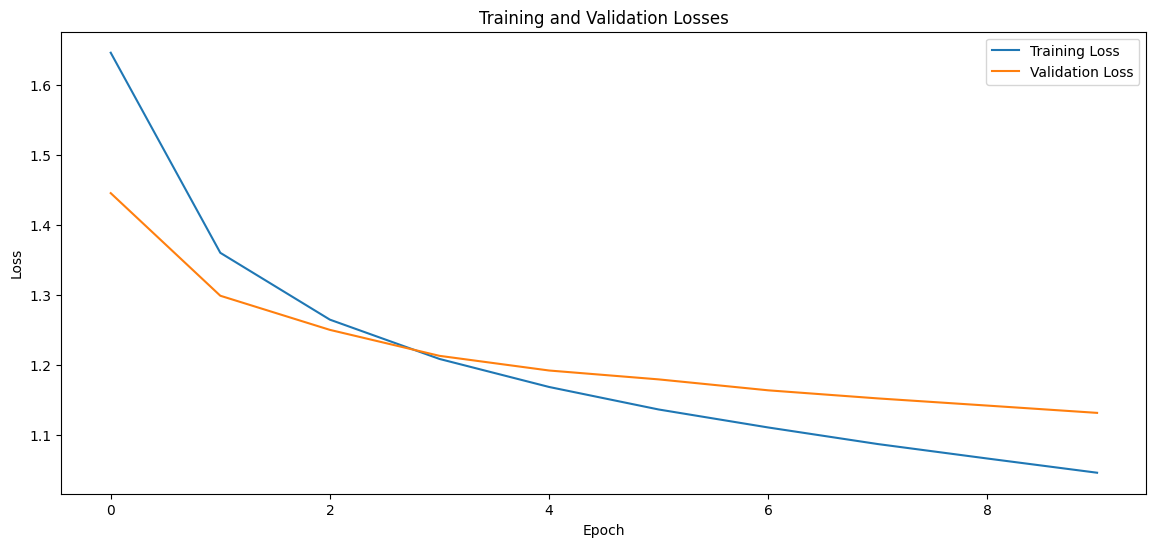

In [ ]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

# Make predictions
y_pred = cnn.predict(X_test)

# Calculate performance metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Accuracy: 0.5900
Precision: 0.6214
Recall: 0.5900


# CNN Pytorch

In [ ]:
class Pytorch_ResidualCNN(nn.Module):
    def __init__(self):
        super(Pytorch_ResidualCNN, self).__init__()

        # Residual connection layers
        self.residual1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=1, stride=1, padding=0)
        self.residual2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=1, stride=1, padding=0)

        # Convolutional layers
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)

        # Pooling layers
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)  # First pooling layer
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)  # Second pooling layer

        # Fully connected layers
        self.flatten = nn.Flatten()  # To flatten the feature maps
        self.fc1 = nn.Linear(32 * 4 * 4, 128)  # Input size: 32 x 4 x 4 = 512
        self.fc2 = nn.Linear(128, 6)  # Output size: 6 (number of classes)

    def forward(self, x):
        # Residual connection 1
        residual = self.residual1(x)  # 16 x H x W
        x = self.conv1(x)  # 16 x H x W
        x = F.relu(x)  # Activation
        x = x + residual  # Add residual connection

        # First Pooling
        x = self.pool1(x)  # Reduce spatial dimensions (H/2, W/2)

        # Residual connection 2
        residual = self.residual2(x)  # 32 x H x W
        x = self.conv2(x)  # 32 x H x W
        x = F.relu(x)  # Activation
        x = x + residual  # Add residual connection

        # Second Pooling
        x = self.pool2(x)  # Reduce spatial dimensions further

        # Flatten the feature maps
        x = self.flatten(x)

        # Fully connected layers
        x = self.fc1(x)
        x = F.relu(x)  # Activation for fc1
        x = self.fc2(x)
        x = F.softmax(x, dim=1)  # Softmax activation for output

        return x


In [ ]:
# Printing model summary

from torchsummary import summary
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model_to_analyse = Pytorch_ResidualCNN().to(device)
print(model_to_analyse)

summary(model_to_analyse, (3, 16, 16))

Pytorch_ResidualCNN(
  (residual1): Conv2d(3, 16, kernel_size=(1, 1), stride=(1, 1))
  (residual2): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1))
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (fc1): Linear(in_features=512, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 16, 16]              64
            Conv2d-2           [-1, 16, 16, 16]             448
         MaxPool2d-3             [-1, 16, 8, 8]               0
            Conv2d-4             [

Epoch 1/10: Training loss = 1.654524101855907, Validation loss = 1.5860957722914846
Epoch 2/10: Training loss = 1.541963057315096, Validation loss = 1.5542091946852834
Epoch 3/10: Training loss = 1.5051914948098204, Validation loss = 1.536340788791054
Epoch 4/10: Training loss = 1.489714871061609, Validation loss = 1.50092865918812
Epoch 5/10: Training loss = 1.4772878149722486, Validation loss = 1.5238626191490574
Epoch 6/10: Training loss = 1.466296688039252, Validation loss = 1.4887537893496061
Epoch 7/10: Training loss = 1.4509343010313966, Validation loss = 1.466193675994873
Epoch 8/10: Training loss = 1.4429112837669698, Validation loss = 1.4741248896247463
Epoch 9/10: Training loss = 1.4339616450857608, Validation loss = 1.4531926983281185
Epoch 10/10: Training loss = 1.41473698996483, Validation loss = 1.4472308786291825


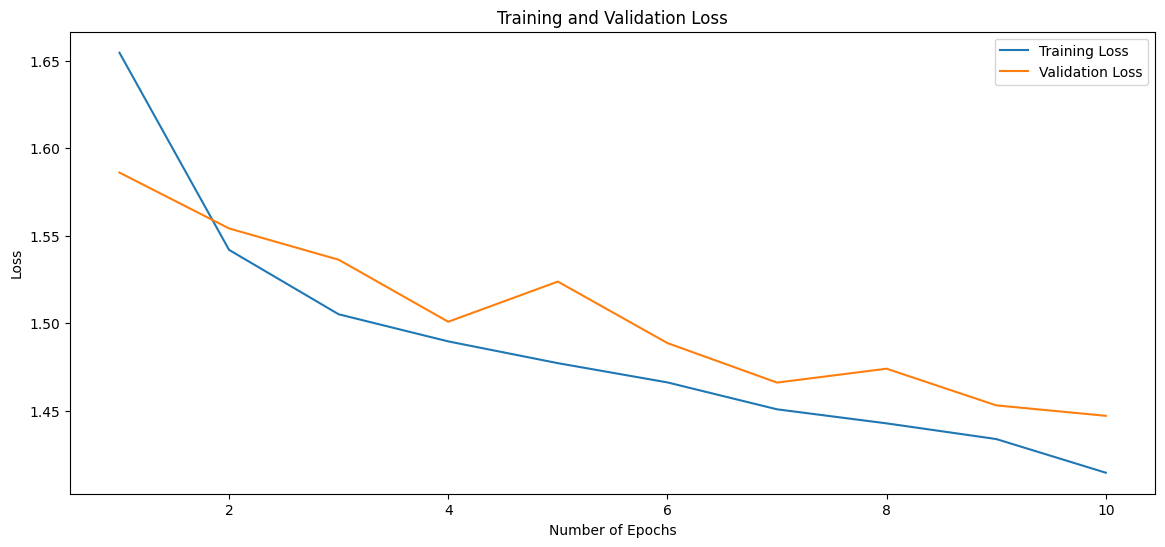

In [ ]:
# Selecting the appropriate training device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Pytorch_ResidualCNN().to(device)

# Defining the model hyperparameters
num_epochs = 10
learning_rate = 0.001
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Lists to store loss values
train_loss_list = []
val_loss_list = []

# Training process begins
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:', end=' ')
    train_loss = 0
    val_loss = 0

    # Training loop
    model.train()
    for i, (images, labels) in enumerate(train_loader):
        # Extracting images and target labels for the batch being iterated
        images = images.to(device)
        labels = labels.to(device)

        # Calculating the model output and the cross-entropy loss
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Updating weights according to calculated loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    # Calculate average losses
    avg_train_loss = train_loss / len(train_loader)
    avg_val_loss = val_loss / len(test_loader)
    train_loss_list.append(avg_train_loss)
    val_loss_list.append(avg_val_loss)

    # Print epoch loss
    print(f"Training loss = {avg_train_loss}, Validation loss = {avg_val_loss}")

# Plotting loss for all epochs
plt.plot(range(1, num_epochs + 1), train_loss_list, label="Training Loss")
plt.plot(range(1, num_epochs + 1), val_loss_list, label="Validation Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
import numpy as np

# Switch to evaluation mode
model.eval()

# Variables to store predictions and true labels
all_preds = []
all_labels = []

# Disable gradient computation
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        # Collect predictions and true labels
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Convert to NumPy arrays for evaluation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate evaluation metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
conf_matrix = confusion_matrix(all_labels, all_preds)

# Print results
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Optional: Detailed classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=[str(i) for i in range(6)]))

Accuracy: 0.5917
Precision: 0.5906
Recall: 0.5917

Confusion Matrix:
[[52 13  4 14  1 16]
 [ 2 84  0  1  1 12]
 [11  3 60 16  7  3]
 [12  6  9 60 11  2]
 [14  6 23 19 30  8]
 [16 10  3  2  0 69]]

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.52      0.50       100
           1       0.69      0.84      0.76       100
           2       0.61      0.60      0.60       100
           3       0.54      0.60      0.57       100
           4       0.60      0.30      0.40       100
           5       0.63      0.69      0.66       100

    accuracy                           0.59       600
   macro avg       0.59      0.59      0.58       600
weighted avg       0.59      0.59      0.58       600

